In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import yaml

from tabulate import tabulate

sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
from preprocessing.opp_preprocess import *
from model.hierarchical_self_attention_model import HSA_model_session_guided_window

In [3]:
data_path = '/home/hariub/data/HAR/processed/clean_opp_nodrill.csv'
df = pd.read_csv(data_path)

metadata_file = open('../configs/metadata.yaml', mode='r')
metadata = yaml.load(metadata_file, Loader=yaml.FullLoader)['opp_preprocess']
FEATURES = [str(i) for i in range(77)]
LOCO_LABEL_COL = 77
MID_LABEL_COL = 78
HI_LABEL_COL = 79
SUBJECT_ID = 80
RUN_ID = 81

# df = df[df[str(HI_LABEL_COL)] != 0]
df[FEATURES] = df[FEATURES].interpolate(method='linear', axis=0)
df = df.fillna(0)

scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

In [4]:
NOVEL_CLASSES = [0]

In [5]:
holdout_data = df.loc[df[str(MID_LABEL_COL)].isin(NOVEL_CLASSES)]
novel_data = holdout_data.copy().reset_index(drop=True)

df = df.drop(holdout_data.copy().index)
df = df.reset_index(drop=True)

In [6]:
BENCHMARK_TEST = ((df[str(SUBJECT_ID)] == 2) | (df[str(SUBJECT_ID)] == 3)) & (
            (df[str(RUN_ID)] == 4) | (df[str(RUN_ID)] == 5))

train_df = df[~ BENCHMARK_TEST]
test_df = df[BENCHMARK_TEST]

SLIDING_WINDOW_LENGTH = 30
SLIDING_WINDOW_STEP = 15
N_WINDOW, N_TIMESTEP = 10, 3

X_train, y_train, m_labels_tr, loco_labels_tr = create_windowed_dataset_opp(train_df, FEATURES, str(
    MID_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_test, y_test, m_labels_ts, loco_labels_ts = create_windowed_dataset_opp(test_df, FEATURES, str(
    MID_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_train = X_train.reshape(
    (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape(
    (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [7]:
X_holdout, y_holdout, m_labels_holdout, loco_labels_holdout = create_windowed_dataset_opp(novel_data,FEATURES,str(
    MID_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)

X_holdout = X_holdout.reshape((X_holdout.shape[0], N_WINDOW, N_TIMESTEP, 77))
y_holdout = tf.keras.utils.to_categorical(y_holdout)

In [8]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


print(X_holdout.shape)
print(y_holdout.shape)

(4637, 10, 3, 77)
(4637, 18)
(1038, 10, 3, 77)
(1038, 18)
(34946, 10, 3, 77)
(34946, 1)


In [9]:
y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=N_WINDOW, axis=1)
# y_val_mid = np.repeat(np.expand_dims(y_val, axis=1), repeats=N_WINDOW, axis=1)
y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=N_WINDOW, axis=1)

y_holdout_mid = np.repeat(np.expand_dims(y_holdout, axis=1), repeats=N_WINDOW, axis=1)

In [10]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
DATASET_NAME = 'opp'
hparams_all = hyperparameters['HSA_model']
hparams = hparams_all[DATASET_NAME]

hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
hparams['n_outputs_window']=  y_train.shape[1]

## Training

In [11]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

8 Physical GPUs, 8 Logical GPUs


In [12]:
device_list = ['/gpu:'+str(i) for i in range(5, 8)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_session_guided_window(**hparams).get_compiled_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 3


In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 3, 77)]  0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 64), ( 754112      input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_7 (Modal (None, None, 64)     104000      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 64), (None,  49856       modality_encoder_block_7[0][0]   
____________________________________________________________________________________________

In [14]:
checkpoint_filepath = "opp_vae_checkpoints/cp-{epoch:04d}.ckpt"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True)                            

In [15]:
model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 128, epochs=60, validation_split=0.1, use_multiprocessing=True, callbacks=[model_checkpoint_callback])

Epoch 1/60
INFO:tensorflow:batch_all_reduce: 292 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/devi

In [16]:
pred_mid, pred_sess = model.predict(X_test, batch_size=len(device_list) * 64)

In [17]:
activity_list = ['Other', 'Open Door 1', 'Open Door 2', 'Close Door 1',
                    'Close Door 2', 'Open Fridge', 'Close Fridge', 
                    'Open Dishwasher', 'Close Dishwasher', 'Open Drawer 1', 
                    'Close Drawer 1', 'Open Drawer 2', 'Close Drawer 2', 
                    'Open Drawer 3', 'Close Drawer 3', 'Clean Table', 
                    'Drink from Cup', 'Toggle Switch']

In [18]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), target_names=activity_list[1:]))

                  precision    recall  f1-score   support

     Open Door 1       0.72      0.76      0.74        38
     Open Door 2       0.94      0.94      0.94        66
    Close Door 1       0.64      0.85      0.73        41
    Close Door 2       0.89      0.93      0.91        54
     Open Fridge       0.94      0.84      0.89       141
    Close Fridge       0.82      0.95      0.88        88
 Open Dishwasher       0.72      0.91      0.81        57
Close Dishwasher       0.77      0.86      0.81        42
   Open Drawer 1       0.44      0.40      0.42        20
  Close Drawer 1       0.39      0.50      0.44        24
   Open Drawer 2       0.55      0.57      0.56        21
  Close Drawer 2       0.21      0.33      0.26        12
   Open Drawer 3       0.89      0.69      0.78        36
  Close Drawer 3       0.88      0.50      0.64        30
     Clean Table       0.98      0.88      0.93        73
  Drink from Cup       0.96      0.87      0.91       234
   Toggle Swi

In [19]:
# import json
# activity_map = json.load(open(os.path.join('..','data', 'activity_maps', 'opp_activity.json')))

<AxesSubplot:>

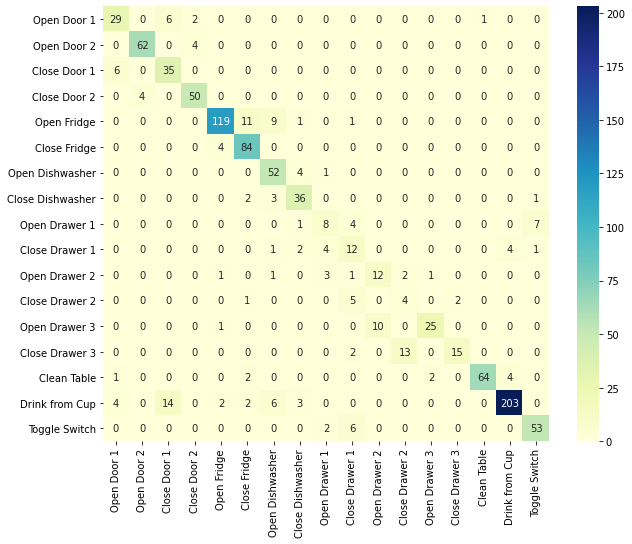

In [20]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1))
df_cm = pd.DataFrame(confm, index=activity_list[1:], columns=activity_list[1:])
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

## VAE

In [21]:
for l in model.layers:
    print(l.name)

input_1
multi_window_encoder
modality_encoder_block_7
combined_sensor_self_attention_1
tf_op_layer_Shape
tf_op_layer_ExpandDims
tf_op_layer_strided_slice_7
tf_op_layer_strided_slice_8
tf_op_layer_Tile
tf_op_layer_concat
tf_op_layer_Reshape
reshape
concatenate
dense_108
dense_109
window_pred
session_pred


In [22]:
hierarchical_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('combined_sensor_self_attention_1').output, name='hierarchical_encoder')
hierarchical_model.trainable = False

In [23]:
hierarchical_model.summary()

Model: "hierarchical_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 3, 77)]       0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 754112    
_________________________________________________________________
modality_encoder_block_7 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 49856     
Total params: 907,968
Trainable params: 0
Non-trainable params: 907,968
_________________________________________________________________


In [24]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs

        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(tf.keras.layers.Layer):

    def __init__(self, latent_dim=16, intermediate_dim=32, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        
        return z_mean, z_log_var, z


class Decoder(tf.keras.layers.Layer):

    def __init__(self, original_dim, intermediate_dim=32, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = tf.keras.layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        return self.dense_output(x)

class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        base_model,
        original_dim,
        intermediate_dim=128,
        latent_dim=16,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.base_model = base_model
        
        self.original_dim = original_dim
        
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        inputs, _ = self.base_model(inputs)
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            data, _ = self.base_model(data)
            z_mean, z_log_var, z = self.encoder(data)
            reconstructed = self.decoder(z)

            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

            reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(data, reconstructed))
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [25]:
hsa_vae = VariationalAutoEncoder(base_model=hierarchical_model, original_dim=64)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
hsa_vae.compile(optimizer)    

vae_history = hsa_vae.fit(X_train, epochs=80, batch_size=128)

Epoch 1/80
37/37 [==============================] - 2s 47ms/step - loss: 1.4781 - reconstruction_loss: 1.3551 - kl_loss: 0.1230
Epoch 2/80
37/37 [==============================] - 2s 44ms/step - loss: 1.2445 - reconstruction_loss: 1.2205 - kl_loss: 0.0240
Epoch 3/80
37/37 [==============================] - 2s 44ms/step - loss: 1.1895 - reconstruction_loss: 1.1686 - kl_loss: 0.0209
Epoch 4/80
37/37 [==============================] - 2s 43ms/step - loss: 1.1628 - reconstruction_loss: 1.1347 - kl_loss: 0.0281
Epoch 5/80
37/37 [==============================] - 2s 44ms/step - loss: 1.1428 - reconstruction_loss: 1.1046 - kl_loss: 0.0381
Epoch 6/80
37/37 [==============================] - 2s 44ms/step - loss: 1.1295 - reconstruction_loss: 1.0854 - kl_loss: 0.0440
Epoch 7/80
37/37 [==============================] - 2s 44ms/step - loss: 1.1186 - reconstruction_loss: 1.0728 - kl_loss: 0.0457
Epoch 8/80
37/37 [==============================] - 2s 44ms/step - loss: 1.1130 - reconstruction_loss: 1

## Novelty Result

In [26]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])

In [27]:
def kl_div(z_mean, z_log_var):
    kl_loss = -0.5 * tf.math.reduce_mean((z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1), axis=1)
    return kl_loss.numpy()

In [28]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_train)[0])
train_kl = kl_div(z_mean, z_log_var)

In [29]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_test)[0])
test_kl = kl_div(z_mean, z_log_var)

In [30]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])
holdout_kl = kl_div(z_mean, z_log_var)

In [31]:
def novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.25):
    threshold = np.mean(train_kl) - (mult * np.std(train_kl))
    
    y_holdout = (holdout_kl > threshold).astype(int)
    y_true = np.ones(shape=holdout_kl.shape, dtype=int)
    
    y_test_n = (test_kl > threshold).astype(int)
    _y_true = np.zeros(shape=test_kl.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
#     return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro')
    
    print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [32]:
novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.75)

              precision    recall  f1-score   support

       KNOWN       0.02      0.22      0.03      1038
       NOVEL       0.96      0.58      0.72     34946

    accuracy                           0.57     35984
   macro avg       0.49      0.40      0.38     35984
weighted avg       0.93      0.57      0.70     35984



In [33]:
train_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_train)[0], hsa_vae.predict(X_train)).numpy()
test_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_test)[0], hsa_vae.predict(X_test)).numpy()
novel_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_holdout)[0], hsa_vae.predict(X_holdout)).numpy()

In [34]:
train_rec_loss.shape

(4637,)

In [35]:
novel_rec_loss.shape

(34946,)

<AxesSubplot:ylabel='Count'>

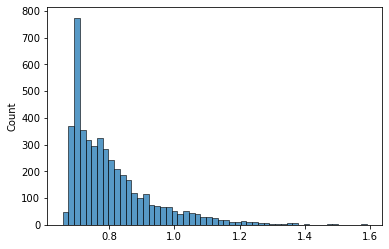

In [40]:
sns.histplot(train_rec_loss)

<AxesSubplot:ylabel='Count'>

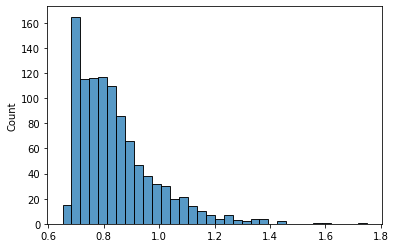

In [41]:
sns.histplot(test_rec_loss)

<AxesSubplot:ylabel='Count'>

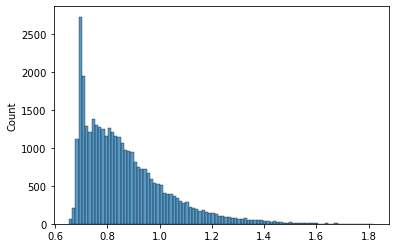

In [42]:
sns.histplot(novel_rec_loss)

<AxesSubplot:xlabel='data', ylabel='Probability'>

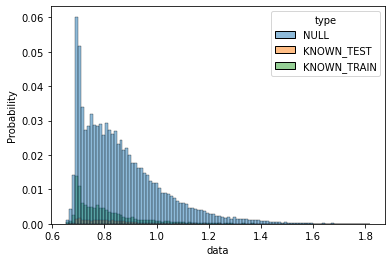

In [56]:
combined = pd.DataFrame({'data': novel_rec_loss, 'type': 'NULL'})
combined = pd.concat([combined, pd.DataFrame({'data': test_rec_loss, 'type': 'KNOWN_TEST'})])
combined = pd.concat([combined, pd.DataFrame({'data': train_rec_loss, 'type': 'KNOWN_TRAIN'})])
sns.histplot(combined, x='data', hue='type', stat="probability")

<AxesSubplot:xlabel='data', ylabel='Probability'>

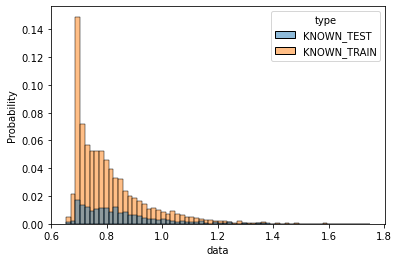

In [59]:
combined = pd.DataFrame()
combined = pd.concat([combined, pd.DataFrame({'data': test_rec_loss, 'type': 'KNOWN_TEST'})])
combined = pd.concat([combined, pd.DataFrame({'data': train_rec_loss, 'type': 'KNOWN_TRAIN'})])
sns.histplot(combined, x='data', hue='type', stat="probability")

In [36]:
def novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=0.25):
    threshold = np.mean(train_rec_loss) - (mult * np.std(train_rec_loss))
    
    y_holdout = (novel_rec_loss > threshold).astype(int)
    y_true = np.ones(shape=novel_rec_loss.shape, dtype=int)
    
    y_test_n = (test_rec_loss > threshold).astype(int)
    _y_true = np.zeros(shape=test_rec_loss.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
    return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro'), 
    
#     print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [37]:
def hparam_search():
    table = list()
    thresh_vals = list(np.arange(0.0, 1.01, 0.01))
    
    idx = 0
    
    for m_val in thresh_vals:
        result = novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=m_val)
        table.append([idx, m_val, result[0], result[1]])
        
        idx = idx + 1
    
    table = np.array(table)
    sns.lineplot(table[:, 1], table[:, 2], label='Accuracy')
    sns.lineplot(table[:, 1], table[:, 3], label='Macro F1')
    plt.xlabel('Hyperparameter Value')
    plt.title('Novelty Detection Experiement')
    plt.show()
    
    top_acc = np.array(pd.Series(table[:, 2]).nlargest().index)
    top_f1 = np.array(pd.Series(table[:, 3]).nlargest().index)
    
    print('Index with Top Accuracy and Macro F1 : ', top_acc, top_f1)
    print('Most Important Index : ', np.intersect1d(top_acc, top_f1))
    
    print(tabulate(table, headers=['Index', 'Std. Multiplier Value', 'Accuracy', 'Macro F1'], tablefmt="grid"))

/home/hariub/miniconda3/envs/tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/hariub/miniconda3/envs/tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


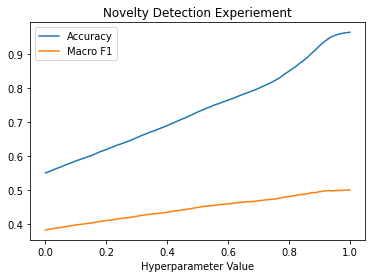

Index with Top Accuracy and Macro F1 :  [100  99  98  97  96] [100  99  98  96  97]
Most Important Index :  [ 96  97  98  99 100]
+---------+-------------------------+------------+------------+
|   Index |   Std. Multiplier Value |   Accuracy |   Macro F1 |
+=========+=========================+============+============+
|       0 |                    0    |   0.549494 |   0.38191  |
+---------+-------------------------+------------+------------+
|       1 |                    0.01 |   0.552885 |   0.383269 |
+---------+-------------------------+------------+------------+
|       2 |                    0.02 |   0.556581 |   0.384967 |
+---------+-------------------------+------------+------------+
|       3 |                    0.03 |   0.560193 |   0.386366 |
+---------+-------------------------+------------+------------+
|       4 |                    0.04 |   0.563806 |   0.387703 |
+---------+-------------------------+------------+------------+
|       5 |                    0.05 | 

In [38]:
# Result
hparam_search() 